# Sim and Focus Multiple Targets

In [1]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
import sys, os
sys.path.append("../../src")
from surface import *
from source import *
from simulator import *
from focus import *

GPU's detected. Enabling CUDA compute


## Simulate to generate radargrams

In [2]:
# generate surface
surf = Surface(origin=(4000, 4000), dims=(400, 400), fs=5, overlap=0)
surf.gen_flat(0)

# generate sources
f0  = 9e6             # center frequency [Hz]
dt  = 1 / (8 * f0)    # time delta to avoid aliasing [s]
n = 1000
# source list
ss = []
for x in np.linspace(-10e3, 20e3, n):
    source = Source(dt, 0.5e-6, (x, 5050, 25000))
    source.chirp(f0, 1e6)
    ss.append(source)

# simulate over target
targets = [(5000, 5000, -1000),
           (4200, 5000, -2500),
           (5800, 5000,  -500)]
rdrgrms = []
slant_range = []
for t in targets:
    print(f"Simulating target @ {t}")
    # simulate over sources
    rdrgrm, sltrng, phase_hist = run_sim_ms(surf, ss, t, reflect=False, phase=True, gpu=False)
    if t == (5000, 5000, -1000):
        slant_range = sltrng
    rdrgrms.append(rdrgrm)

rdrgrm = np.zeros_like(rdrgrm)
for rdr in rdrgrms: rdrgrm += rdr

Simulating target @ (5000, 5000, -1000)
Simulating target @ (4200, 5000, -2500)0:00     
Simulating target @ (5800, 5000, -500)00:00     


## For focusing first estimate slant range

In [3]:
sx = np.linspace(-10e3, 20e3, n)
sz = 25000
c1 = 299792458
c2 = c1 / np.sqrt(3.15)
slantrange_ests = []
for tx, ty, tz in targets:
    slantrange_ests.append(est_slant_range(sx, sz, tx, tz, c1, c2))

**Compute phase history**

In [4]:
k = (2 * np.pi) / 33.3
match_filter_anls = []
for slantrange_est in slantrange_ests:
    match_filter_anls.append(np.exp(-2j * k * slantrange_est))

## Where to focus and with what parameters?

In [5]:
c        = 299792458 # speed of light [m/s]
f_y, y_x = 959, 50   # what pixel to focus? (range bin, trace)
lam      = 33.3      # wavelength [m]
rng_st   = 20e3      # starting range [m]
rng_en   = 50e3      # ending range [m]
rng_res  = 300       # range resolution [m]
sampl    = 48e6      # sampling rate [Hz]
dt       = 1 / sampl # time interval [s]
dt_m     = dt * c    # space interval [m]

# how many range bins?
rb = int(((rng_en - rng_st) / c) / (1 / sampl))

slant_rbs = []
for slantrange_est in slantrange_ests:
    slant_rbs.append(((slantrange_est - rng_st) // dt_m).astype(int))

In [6]:
focuseds = []
for i, rdrgrm in enumerate(rdrgrms):
    focused = focus_jit(rdrgrm, slant_rbs[i], match_filter_anls[i], 4803)
    focuseds.append(focused)

In [7]:
focused = np.sum(focuseds, axis=0)
rdrgrm = np.sum(rdrgrms, axis=0)

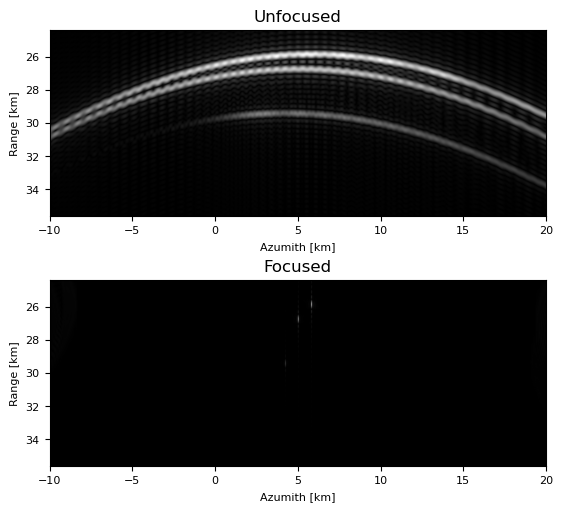

In [11]:
extent = (-10, 20, rng_en/1e3, rng_st/1e3)
fig, ax = plt.subplots(2, figsize=(10, 5), constrained_layout=True)
ax[0].imshow(np.abs(rdrgrm), cmap="gray", aspect=1, extent=extent)
ax[0].set_title("Unfocused")
ax[1].imshow(np.abs(focused), cmap="gray", aspect=1,  extent=extent)
ax[1].set_title("Focused")
for a in ax:
    a.set_ylim((rng_st + 2500 * dt_m)/1e3, (rng_st + 700 * dt_m)/1e3)
    a.set_xlabel("Azumith [km]", fontsize=8)
    a.set_ylabel("Range [km]", fontsize=8)
    a.tick_params(labelsize=8)
plt.show()

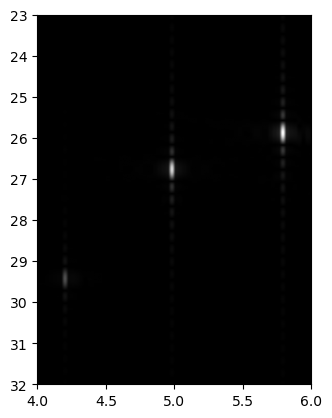

In [12]:
plt.imshow(np.abs(focused), cmap="gray", aspect=0.3, extent=extent)
plt.ylim(32, 23)
plt.xlim(4, 6)
plt.show()

In [10]:
np.save("rdrgrm-offset.npy", rdrgrms[-1])